### LSTM 自動生成音樂

#### _Dataset_
> [Classical Music MIDI](https://www.kaggle.com/datasets/soumikrakshit/classical-music-midi)

#### _參考資料_
> [Music Generation: LSTM](https://www.kaggle.com/code/karnikakapoor/music-generation-lstm/notebook)

#### TABLE OF CONTENTS

1. IMPORTING LIBRARIES

2. LOADING DATA

3. DATA EXPLORATION

4. DATA PREPREPROCESSING

5. MODEL BUILDING

6. EVALUATING MODELS

#### IMPORTING LIBRARIES

In [3]:
#Importing Libraries
import os
from music21 import *
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

#### LOADING DATA

In [4]:
# Getting midi files
composer = os.listdir("../music")[7]
filepath = "../music/" + composer + "/"
all_midis = []
error = []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath + i
        try:
            midi = converter.parse(tr)
        except:
            error.append(i)
        all_midis.append(midi)
print("Composer: {}" .format(composer))
print("Error file: {}" .format(error))

Composer: chopin
Error file: ['chpn_op33_2.mid', 'chpn_op35_2.mid']


In [5]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 58827


#### DATA EXPLORATION

In [6]:
#First Lets write some functions that we need to look into the data
def show(music):
    #display(Image(str(music.write("lily.png"))))
    lily.to_png(lily.from_Bar(music), 'sheet_music')
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
#show(Melody_Snippet)

In [7]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 388


In [8]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 151.6159793814433
Most frequent note in Corpus appeared: 1745 times
Least frequent note in Corpus appeared: 1 time


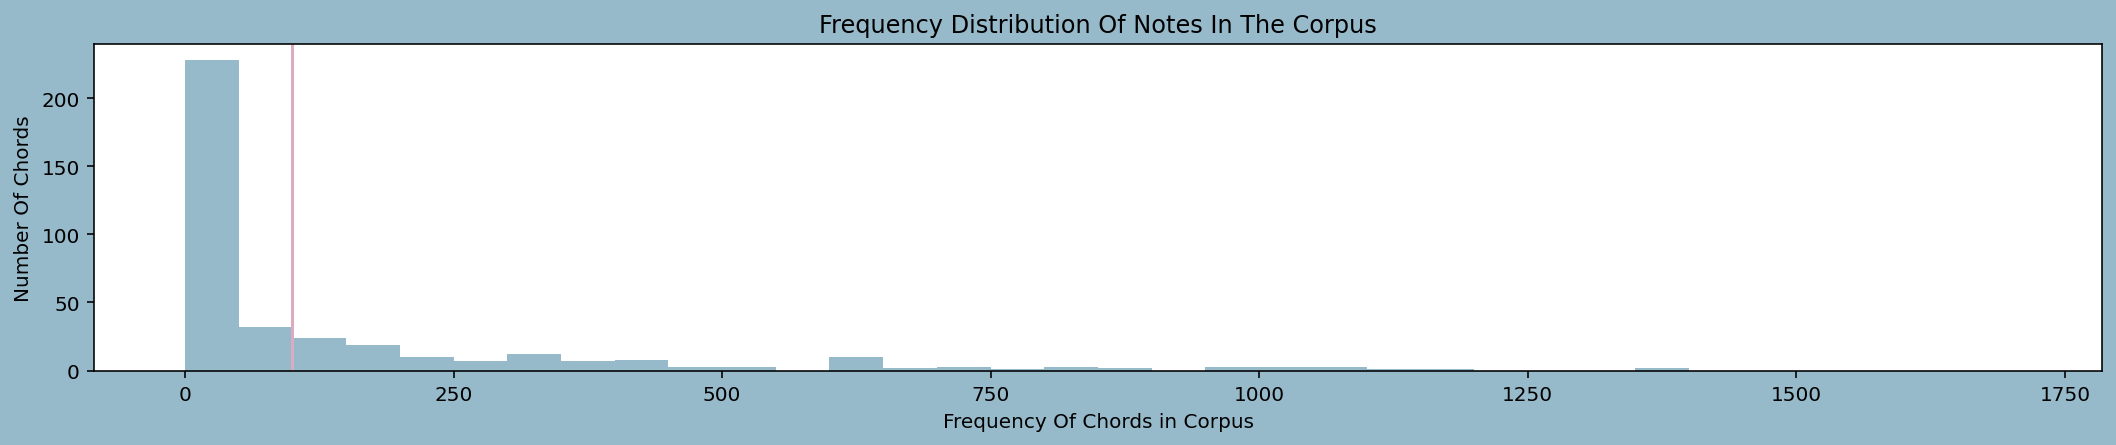

In [9]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [10]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 260


In [11]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 54864


#### DATA PREPROCESSING

In [12]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 54864
Number of unique characters: 247


In [13]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 54864
Number of unique characters: 247


In [14]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 54824


In [15]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets)

In [16]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

#### MODEL BUILDING

In [17]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 247)               63479     
                                                                 
Total params: 1,969,399
Trainable params: 1,969,399
Non-

In [19]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

Epoch 1/200
128/172 [=====================>........] - ETA: 38s - loss: 4.7491

KeyboardInterrupt: 

#### EVALUATING MODELS

[Text(0.5, 0, 'Epochs')]

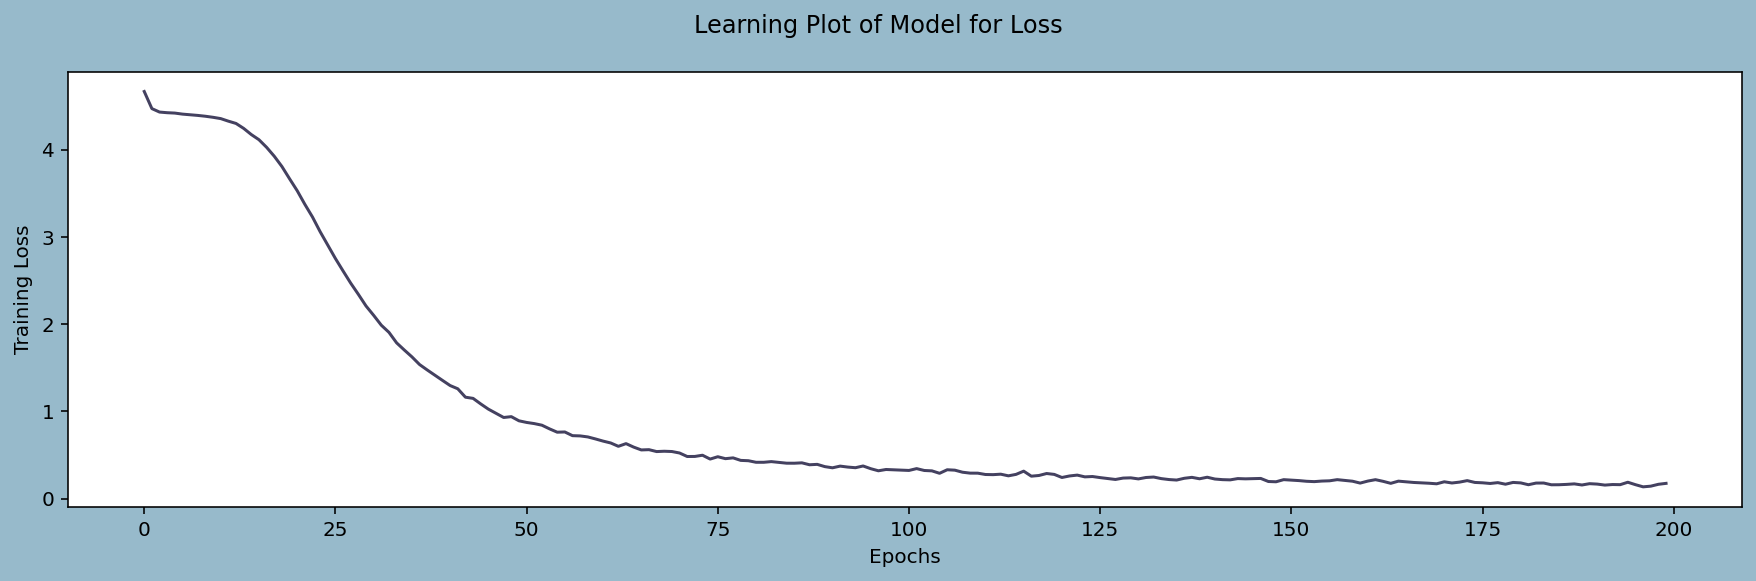

In [ ]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [ ]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    # Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


# getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)

In [ ]:
#To save the generated melody

Melody.write('midi','Melody_Generated.mid')

'Melody_Generated.mid'